In [1]:
import sys, os
from pathlib import Path

import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from tabulate import tabulate
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm
from scipy import misc, signal

from sklearn.neighbors import NearestNeighbors
import networkx as nx
import cv2
import random
import ctypes
from scipy.signal import convolve2d

from omnibelt import load_yaml, save_yaml, multi_index

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.segmentation import *
from skimage.segmentation import watershed, expand_labels
from skimage.morphology import closing, square, dilation
from skimage.color import label2rgb
from PIL import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
def show(im):
    plt.figure()
    plt.imshow(im.astype(int))
    plt.axis('off')
    plt.subplots_adjust(0,0,1,1)
    
def show_region(ind, clean, im, regions):
    region = regions[ind]
    y1, x1, y2, x2 = region.bbox
    x, y = x1, y1
    h = y2 - y1
    w = x2 - x1
    cy, cx = region.centroid

    img = clean.copy()
    sel = im == ind + 1
    img[sel] = [255, 0, 0]

    show(img)

    r = 1000
    if h < r:
        h = r
        y = cy - r / 2
    if w < r:
        w = r
        x = cx - r / 2

    plt.xlim(x, x + w)
    plt.ylim(y + h, y)
    
def extend(slic, num=1):
    new = []
    for s in slic:
        new.append(slice(max(0,s.start-num), s.stop+num))
    return tuple(new)

def fix_border_order(coords):
    clf = NearestNeighbors(n_neighbors=2).fit(coords)
    G = clf.kneighbors_graph()
    T = nx.from_scipy_sparse_matrix(G)

    orders = [np.array(list(nx.dfs_preorder_nodes(T, min(piece))), dtype='int')
              for piece in nx.connected_components(T)]
    return orders

def boundary_midpoint(idx, sub, neighbors, offset=None):

    bd = find_boundaries((sub == idx), mode='outer')
    breg = regionprops(bd.astype(int))[0]

    coords = breg.coords

    clf = NearestNeighbors(n_neighbors=2).fit(coords)
    G = clf.kneighbors_graph()
    T = nx.from_scipy_sparse_matrix(G)

    valids = []

    pieces = list(nx.connected_components(T))
    for piece in pieces:

        order = np.array(list(nx.dfs_preorder_nodes(T, min(piece))), dtype='int')

        fixed = sub[bd][order]

        sel = fixed == neighbors[0]
        for n in neighbors[1:]:
            sel += fixed == n
        valids.append((sel, order))

    best, order = max(valids, key=lambda x: x[0].sum())
    options = order[best]
    x,y = coords[options[len(options)//2]]

    if offset is not None:
        x += offset[0]
        y += offset[1]
    return x,y

def load_image(path):
    im = Image.open(str(path))
    im = np.array(im)
    return im

import ctypes

def GetTextDimensions(text, points, font):
    class SIZE(ctypes.Structure):
        _fields_ = [("cx", ctypes.c_long), ("cy", ctypes.c_long)]

    hdc = ctypes.windll.user32.GetDC(0)
    hfont = ctypes.windll.gdi32.CreateFontA(points, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, font)
    hfont_old = ctypes.windll.gdi32.SelectObject(hdc, hfont)

    size = SIZE(0, 0)
    ctypes.windll.gdi32.GetTextExtentPoint32A(hdc, text, len(text), ctypes.byref(size))

    ctypes.windll.gdi32.SelectObject(hdc, hfont_old)
    ctypes.windll.gdi32.DeleteObject(hfont)

    return (size.cx, size.cy)

def place_contents(space, objs):
    
    space = space.copy().astype(np.uint8)
    
    cxs = []
    for kernel in objs:
        
        distmap = cv2.distanceTransform(space, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
#         show(distmap)
        
        if kernel is None:
            best = np.argwhere(distmap==distmap.max())[0]
            cxs.append(best)
            x,y = cxs[-1]
            space[x,y] = 0
        else:
            C = cv2.filter2D(distmap, -1, kernel) # Convolve
            cxs.append(np.argwhere(C==C.max())[0])
            x,y = cxs[-1]
            w,h = kernel.shape
            x -= w//2
            y -= h//2
            space[x:x+w,y:y+h] = 0
            
    cxs = np.stack(cxs)
    return cxs[:,::-1]
    

In [3]:
root = Path('extra/col/adj')
root.mkdir(exist_ok=True)

In [4]:
players = load_yaml(root/'players.yaml')
full = load_yaml(root/'graph.yaml')
bgs = load_yaml(root/'backgrounds.yaml')
pois = load_yaml(root/'pois.yaml')

In [5]:
idents = load_yaml('extra/col/col_idents_v2.yaml')
resps = idents['fields']

In [6]:
bgs['ANT']

{'env': 'ocean',
 'idx': 926,
 'name': 'ANT',
 'pos': [4639.1433013000915, 5387.718866510107],
 'type': 'sea'}

In [7]:
rim = load_image(root/'region_inds.png')
im = load_image(root/'col_fixed_v2_nodes.png')

In [8]:
regions = regionprops(rim)
fields = regionprops(im)
len(regions), len(fields)

(1304, 934)

In [15]:

borders = find_boundaries(im, connectivity=1, mode='thick', background=0)

nice = im.copy()

nice[borders == 1] = 0

clean = nice.copy().clip(max=1)
clean = np.stack(3 * [clean], 2) * 255

In [16]:
names = list(full)

In [17]:
eccs = [fields[full[name]['idx']].eccentricity for name in names]
orients = [fields[full[name]['idx']].orientation for name in names]
exts = [fields[full[name]['idx']].extent for name in names]
ratios = [fields[full[name]['idx']].minor_axis_length/fields[full[name]['idx']].major_axis_length for name in names]

In [18]:
# print(tabulate(sorted(zip(names,ratios), key=lambda x: x[1], reverse=True)))

In [192]:
name = 'Mexico City'
name = 'Santa Fe'
# name = random.choice(names)

# name = 'Piedmont'
# name = 'Sar.'

# name = 'Malaga'
# name = 'Hainan'

# name = 'Nouvelle Orleans'

print(name)

info = full[name]
idx = info['idx']
field = fields[idx]
if 'water' in info:
    field = fields[bgs[info['water']]['idx']]
    print('Using water tile')
sub = field.image
info

Santa Fe


{'army-edges': ['Santa Tecla',
  'Banda Oriental',
  'Rio del la Plata',
  'Rosario'],
 'env': 'coast',
 'idx': 886,
 'name': 'Santa Fe',
 'navy-edges': ['Banda Oriental', 'Lagoa dos Patos', 'Rio del la Plata'],
 'pos': [3754.7012178619757, 2361.9305818673884],
 'type': 'coast'}

<IPython.core.display.Javascript object>


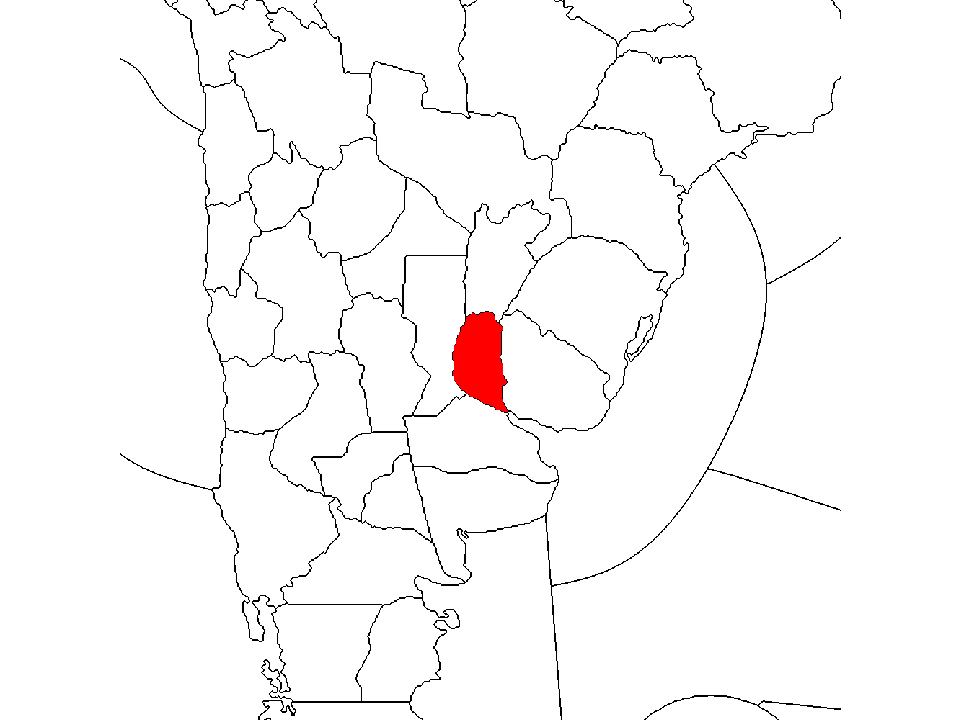

In [193]:
show_region(idx, clean=clean, im=im, regions=fields)

In [143]:
# import math
# props = field
# ax = plt.gca()
# y0, x0 = props.centroid
# orientation = props.orientation
# x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
# y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
# x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
# y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

# ax.plot((x0, x1), (y0, y1), '-b', linewidth=2.5)
# ax.plot((x0, x2), (y0, y2), '-b', linewidth=2.5)
# ax.plot(x0, y0, '.g', markersize=15)

# minr, minc, maxr, maxc = props.bbox
# bx = (minc, maxc, maxc, minc, minc)
# by = (minr, minr, maxr, maxr, minr)
# ax.plot(bx, by, '-b', linewidth=2.5)
# field.orientation, field.eccentricity, field.extent

In [144]:
# bd = find_boundaries(sub, mode='outer')
# breg = regionprops(bd.astype(int))[0]
# show(bd)

In [145]:
# coords = breg.coords
# coords.shape

In [146]:
info['pos']

[2012.431282261849, 1131.081739793524]

In [147]:
# image = np.full((480, 640), 255, np.uint8)
# cv2.circle(image, (320, 240), 100, 0)

In [151]:
if info['type'] == 'coast':
    edges = info['navy-edges']
    if isinstance(edges, dict):
        for name,es in edges.items():
            print(name)
            neighbors = [full[e]['idx']+1 for e in es if full[e]['type'] == 'sea']
            break
    else:
        
        neighbors = [full[e]['idx']+1 for e in edges if full[e]['type'] == 'sea']

NC


In [152]:
bd = find_boundaries(im==idx+1, mode='outer')
breg = regionprops(bd.astype(int))[0]

In [153]:
raw = breg.coords

# neighbors = [389]
sub = im[breg.slice]
fixed = sub[breg.image.astype(bool)]
sel = fixed == neighbors[0]
for n in neighbors[1:]:
    sel += fixed == n
sel = sel.astype(bool)
picks = raw[sel]
ords = fix_border_order(picks)

coasts = [picks[o] for o in ords]
coords = raw[fix_border_order(raw)[0]]

neighbors, len(coasts)

([468], 1)

In [154]:
coast = coasts[0]
coast[len(coast)//2]

array([1986, 1190], dtype=int64)

In [158]:
rats = np.linspace(0,1,7)[1:-1]
rats

array([0.16666667, 0.33333333, 0.5       , 0.66666667, 0.83333333])

<IPython.core.display.Javascript object>


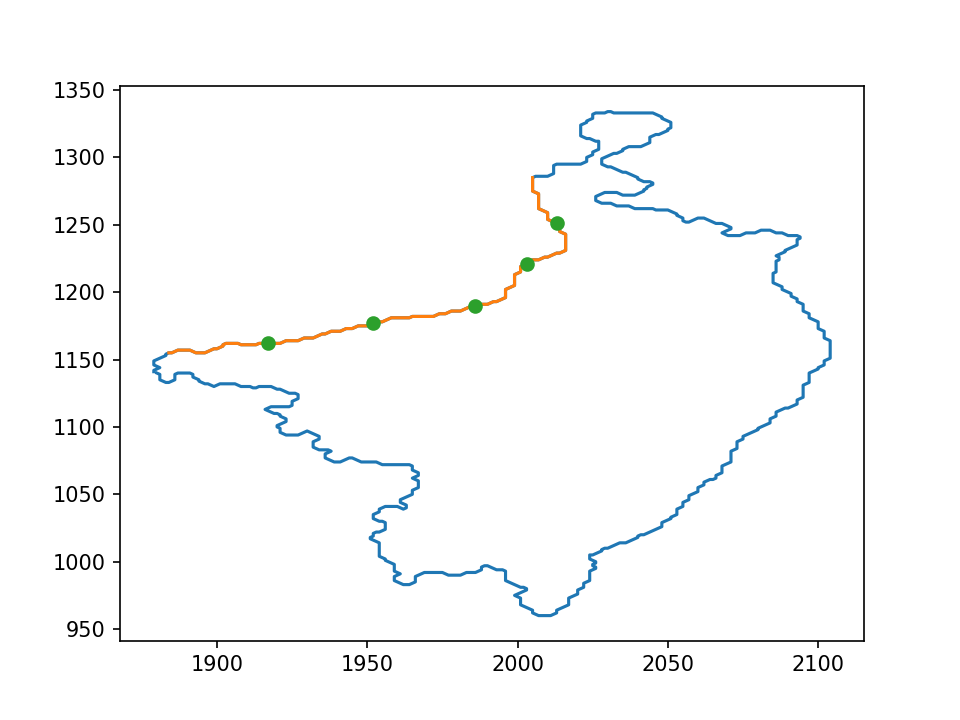

In [159]:
plt.figure()
plt.plot(*coords.T);
plt.plot(*coasts[0].T);
plt.plot(*coast[(len(coast)*rats).astype(int)].T, marker='o', ls='');

In [157]:

# coasts

<IPython.core.display.Javascript object>


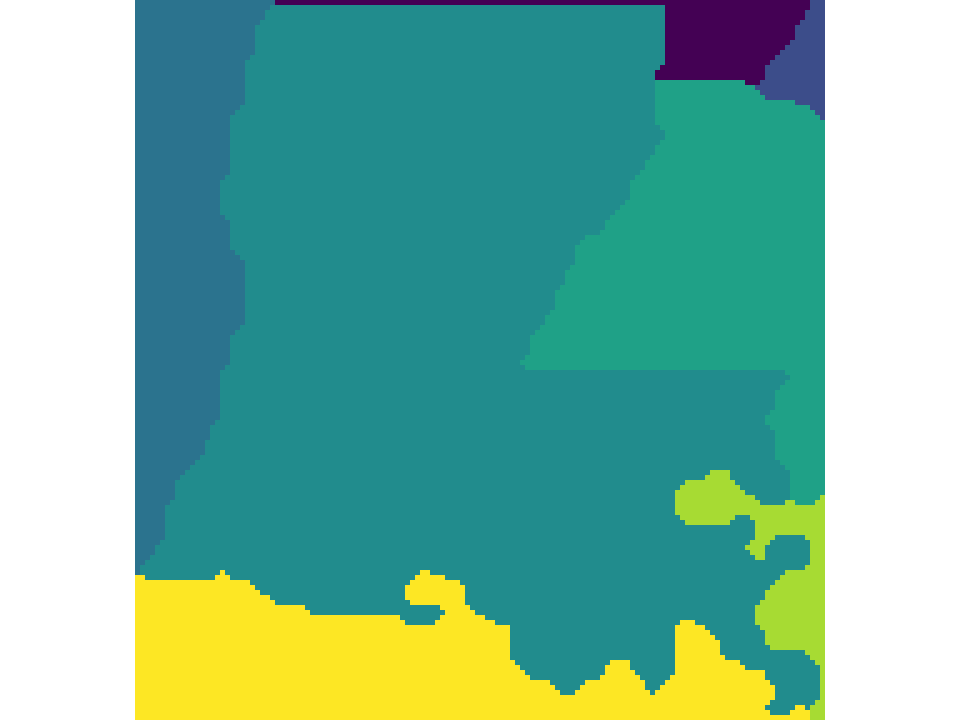

In [100]:
show(sub)

In [93]:
# inds = sub[bd]
# inds

In [24]:
label_size = GetTextDimensions(name, 16, "Arial")
pts = place_contents(sub, [np.ones(label_size).T, None, None, None])

<IPython.core.display.Javascript object>


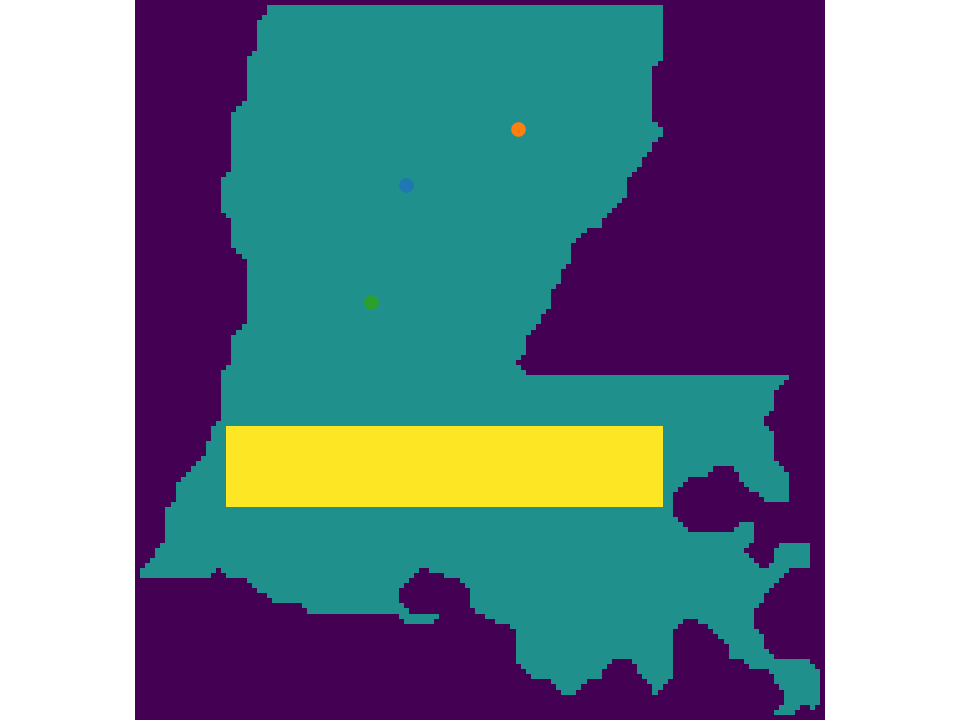

In [25]:
exm = sub.copy().astype(np.uint8)
h,w = label_size
ly,lx = pts[0]
ly -= h//2
lx -= w//2
exm[lx:lx+w,ly:ly+h] = 2
show(exm)
for i, (X,Y) in enumerate(pts[1:]):
    plt.plot(X,Y,ls='',marker='o',color=f'C{i}')

In [356]:
pts, timg = place_contents(sub, [np.ones(label_size), None, None, None])
pts

[array([58, 50], dtype=int64)]

In [17]:
# show(timg)

In [18]:
# distmap = cv2.distanceTransform(sub.astype(np.uint8), cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
# show(distmap)

In [348]:
label_size = GetTextDimensions(name, 16, "Arial")
h,w = label_size

kernel = np.ones(label_size)

A = distmap
B = kernel.T
C = cv2.filter2D(A, -1, B) # Convolve

x,y = np.argwhere(C==C.max())[0]
cx = x,y
x -= w//2
y -= h//2

In [27]:
# D = distmap.copy()
# D[x:x+w,y:y+h] = 0
# show(D)

In [383]:
locs = {}

In [384]:

todo = tqdm([n for n in names if n not in locs])
for name in todo:
    todo.set_description(name)
    info = full[name]
    idx = info['idx']
    field = fields[idx]
    
    loc = {'label': pos[0].tolist(), 'pos': pos[1:].tolist()}
    
    
    if 'water' in info:
        field = fields[bgs[info['water']]['idx']]
        
        sub = field.image
        offset = np.array(field.bbox[:2])[::-1].reshape(1,2)
        pos = place_contents(sub, [np.ones(label_size), None, None, None])
        pos += offset

        loc['water'] = {'label': pos[0].tolist(), 'pos': pos[1:].tolist()}
    
    locs[name] = loc
#     break

  0%|          | 0/869 [00:00<?, ?it/s]

In [385]:
locs['Maldives']

{'label': [6287, 2644],
 'pos': [[6299, 2822], [6302, 2823], [6320, 2476]],
 'water': {'label': [6205, 2695],
  'pos': [[6195, 2588], [6205, 2507], [6389, 2645]]}}

In [399]:
# save_yaml(locs, root/'pois.yaml')

In [180]:
def is_sea(name):
    if name.endswith(' (NC)') or name.endswith(' (SC)') or name.endswith(' (WC)') or name.endswith(' (EC)'):
        return False
    return full[name]['type'] == 'sea'

In [190]:
coast_locs = {}
rats = np.linspace(0,1,7)[1:-1]

In [191]:

todo = tqdm([n for n in names if n not in coast_locs and full[n]['type'] == 'coast'])
for name in todo:
    todo.set_description(name)
    info = full[name]
    idx = info['idx']
    if 'water' in info:
        continue
    field = fields[idx]
    sub = field.image
    map_loc = im[field.slice]
    offset = np.array(field.bbox[:2])[::-1].reshape(1,2)
    
    bd = find_boundaries(sub, mode='outer')
    breg = regionprops(bd.astype(int))[0]
    
    edges = info['navy-edges']
    neighbors = {}
    if isinstance(edges, dict):
        for cname,es in edges.items():
            neighbors[cname] = [full[e]['idx']+1 for e in es if is_sea(e)]
    else:
        neighbors[None] = [full[e]['idx']+1 for e in edges if is_sea(e)]
    
    loc = {}
    for cname, ns in neighbors.items():
        if len(ns):
    
            raw = breg.coords

            # neighbors = [389]
            inds = map_loc[breg.image.astype(bool)]
            sel = inds == ns[0]
            for n in ns[1:]:
                sel += inds == n
            sel = sel.astype(bool)
            picks = raw[sel]
            if len(picks) > 1:
                try:
                    ords = fix_border_order(picks)
                except:
                    print(len(picks), name, cname)
                    raise
                
                coasts = [picks[o] for o in ords]

                best = max(coasts, key=lambda x: len(x))
                
                cxs = best[(len(best)*rats).astype(int)][:,::-1] + offset
                
                loc[cname] = cxs.tolist()
            
    if not len(loc):
        print(name, 'failed')
#         raise Exception(f'{name}')
    else:
        if None in loc:
            coast_locs[name] = loc[None]
        else:
            coast_locs[name] = loc
#     break

  0%|          | 0/410 [00:00<?, ?it/s]

Montreal failed
Santa Fe failed


In [404]:
pick = random.choice(list(locs.keys()))
pick = 'Kingston'


lx = locs[pick]
if 'water' in lx:
    lx = lx['water']

<IPython.core.display.Javascript object>


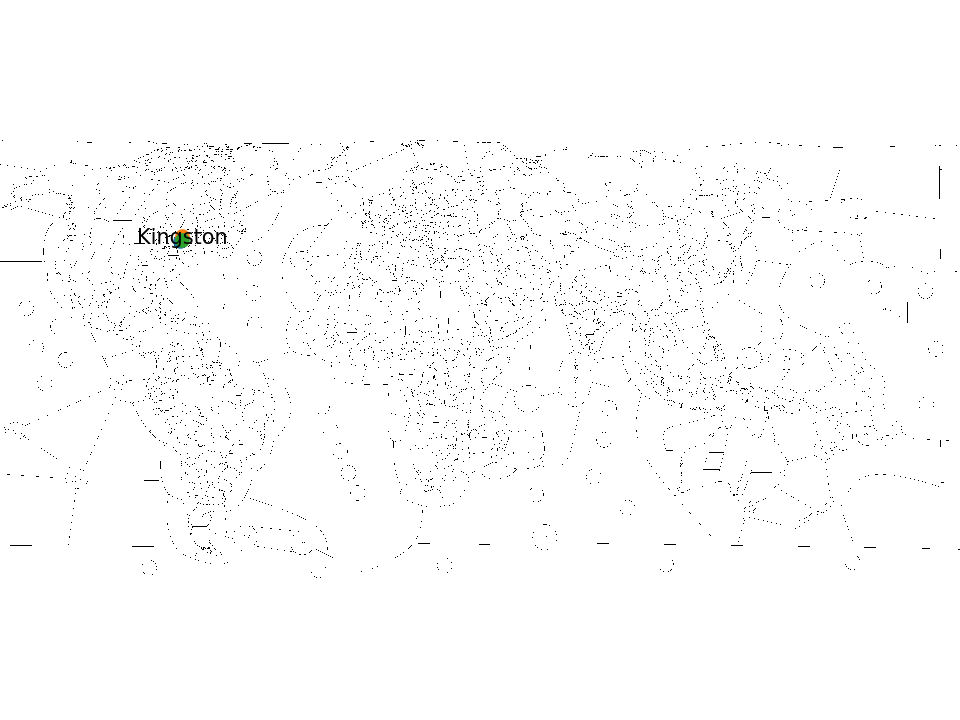

In [405]:
show(clean)

plt.text(*lx['label'], pick, va='center', ha='center')

for i, (X,Y) in enumerate(lx['pos']):
    plt.plot(X,Y,ls='',marker='o',color=f'C{i}')

In [280]:
# from matplotlib.offsetbox import TextArea, VPacker, AnnotationBbox
# fig = plt.figure()
# ax = plt.gca()
# texts = ['alpha','beta','epsilon']
# colors = ['red','cyan','black']
# Texts = []
# for t,c in zip(texts,colors):
#     Texts.append(TextArea(t,textprops=dict(color=c)))
# texts_vbox = VPacker(children=Texts,pad=0,sep=0)
# ann = AnnotationBbox(texts_vbox,(.02,.5),xycoords=ax.transAxes,
#                             box_alignment=(0,.5),bboxprops = 
#                             dict(facecolor='wheat',boxstyle='round',color='black'))
# ann.set_figure(fig)
# fig.artists.append(ann)

In [202]:
# for name, info in full.items():
#     idx = info['idx']
#     info['area'] = fields[idx].area.item()

In [35]:
# save_yaml(full,root/'graph.yaml' )

ImportError: cannot import name 'multi_index' from 'omnibelt' (c:\users\anwan\onedrive\khan\research\belt\omnibelt\__init__.py)

In [5]:
len(full), len(pois)

(867, 869)

In [6]:
set(pois).difference(full)

{'ESA', 'WSA'}

In [5]:
if 'ESA' in pois:
    del pois['ESA']
if 'WSA' in pois:
    del pois['WSA']

In [6]:
general = {'label': ('label',)}
sc = {'sc': ('pos',2)}

fleet = {'occupy':('pos', 0), 'retreat':('pos', 1), }

army = {'occupy':('pos', 0), 'retreat':('pos', 1)}

coast = {'coast-label': ('coast-locs', 2)}
coast_fleet = {'occupy':('coast-locs', 1), 'retreat':('coast-locs', 0),}

In [27]:
missing = []
locs = {}
for name, poi in pois.items():
    info = full[name]
    typ = info['type']
    
    locs[name] = {key: multi_index(poi, *val) for key, val in general.items()}
    
    try:
        if typ == 'sea':
            locs[name]['fleet'] = {key: multi_index(poi, *val) for key, val in fleet.items()}
        elif typ == 'land':
            locs[name].update({key: multi_index(poi, *val) for key, val in sc.items()})
            locs[name]['army'] = {key: multi_index(poi, *val) for key, val in army.items()}
        elif typ == 'coast':
            locs[name].update({key: multi_index(poi, *val) for key, val in sc.items()})
            locs[name]['army'] = {key: multi_index(poi, *val) for key, val in army.items()}

            if isinstance(info['fleet-edges'], dict):
                locs[name].update({key:{coast: multi_index(poi, val[0], coast, *val[1:]) 
                                        for coast in info['fleet-edges']} 
                                   for key, val in coast.items()})

                locs[name]['fleet'] = {key:{coast: multi_index(poi, val[0], coast, *val[1:]) 
                                            for coast in info['fleet-edges']} 
                                       for key, val in coast_fleet.items()}
            elif 'water' in poi:
                locs[name]['fleet'] = {key: multi_index(poi['water'], *val) for key, val in fleet.items()}
                locs[name]['water'] = {key: multi_index(poi['water'], *val) for key, val in {**general, **sc}.items()}
            else:
                locs[name].update({key: multi_index(poi, *val) for key, val in coast.items()})
                locs[name]['fleet'] = {key: multi_index(poi, *val) for key, val in coast_fleet.items()}
        else:
            print(name,'failed')
    except Exception as e:
        print(name)
        missing.append(name)
        print(e)
        
len(locs)

Montreal
'coast-locs'
Santa Fe
'coast-locs'


867

In [34]:
# for name, info in full.items():
#     if name in locs:
#         info['locs'] = locs[name]
#     else:
#         print(name)

In [37]:

label = np.array([2784, 1300])
occupy = np.array([2783, 1254]) - label
retreat = np.array([2783, 1344]) - label
occupy, retreat

(array([ -1, -46]), array([-1, 44]))

In [43]:
lbls = np.array([[288, 1848], [633, 2049], [396, 2277], [715, 2413], [489, 2667],])
snd = np.array([[8937, 1546], [9560, 1608], [10122, 1660], [10236, 2291], [10131, 2897]])
lbls = np.stack([lbls, snd],1)
for row in lbls + occupy:
    print(row.tolist())

[[287, 1802], [8936, 1500]]
[[632, 2003], [9559, 1562]]
[[395, 2231], [10121, 1614]]
[[714, 2367], [10235, 2245]]
[[488, 2621], [10130, 2851]]


In [44]:
for row in lbls + retreat:
    print(row.tolist())

[[287, 1892], [8936, 1590]]
[[632, 2093], [9559, 1652]]
[[395, 2321], [10121, 1704]]
[[714, 2457], [10235, 2335]]
[[488, 2711], [10130, 2941]]


In [1]:
root = 'extra/col/adj/game/graph.yaml'

In [2]:
from omnibelt import save_json, load_yaml

In [3]:
data = load_yaml(root)

In [4]:
len(data)

866

In [5]:
# save_json(data, 'extra/col/adj/game/graph.json')

In [6]:
from tabulate import tabulate

In [7]:
root = 'extra/col/adj/game/states/7-3.yaml'

In [8]:
state = load_yaml(root)
len(state)

4

In [9]:
rows = []
for i, (name, delta) in enumerate(state['adjustments'].items()):
    rows.append([name, len(state['players'][name]['units']), len(state['players'][name]['centers']), delta])
rows = sorted(rows, key=lambda x: x[-1], reverse=True)
for i, row in enumerate(rows):
    row.insert(0, i+1)

In [10]:
print(tabulate(rows, headers=['', 'Name', 'Units', 'Centers', 'Delta']))

    Name                              Units    Centers    Delta
--  ------------------------------  -------  ---------  -------
 1  Russian Empire                       38         44        6
 2  Siam                                 16         22        6
 3  Brandenburg-Prussia                  14         17        3
 4  Cherokee                             10         13        3
 5  Ethiopia                             19         22        3
 6  Algonquian                           12         14        2
 7  Aymara                                5          7        2
 8  Paiute                               13         15        2
 9  Rozwi Empire                         17         19        2
10  Inuit                                 7          8        1
11  Iroquois                             15         16        1
12  Morocco                               6          7        1
13  Swedish Empire                       20         21        1
14  Austrian Empire                     

In [7]:
from collections import OrderedDict

In [8]:
ps = OrderedDict()
num = 6
for yr in range(1,num+1):
    root = f'extra/col/adj/game/states/{yr}-3.yaml'
    state = load_yaml(root)
    for i, (name, delta) in enumerate(state['adjustments'].items()):
        if name not in ps:
            ps[name] = []
        ps[name].append(len(state['players'][name]['centers']))
rows = [[name, *content] for name, content in ps.items()]
print(tabulate(rows, headers=['Name']+[f'170{i}' for i in range(num)]))

Name                              1700    1701    1702    1703    1704    1705
------------------------------  ------  ------  ------  ------  ------  ------
Algonquian                           8       8       8       8       9      12
Austrian Empire                      7       5       5       5       4       4
Aymara                               6       6       6       6       6       7
Brandenburg-Prussia                  6       8      11      12      13      14
British Empire                      26      25      25      24      19      15
Buganda                              7       9       7       4       0       0
Cherokee                             9       9      10      11      12      13
China                               10      10       9       5       2       1
Chukchi                              6       7       8       9      11      13
Darfur                               7       9      10      10       9       8
Dutch Empire                        21      16      

In [11]:
for row in rows:
    print(','.join(map(str,row[1:])))

8,8,8,8,9,12
7,5,5,5,4,4
6,6,6,6,6,7
6,8,11,12,13,14
26,25,25,24,19,15
7,9,7,4,0,0
9,9,10,11,12,13
10,10,9,5,2,1
6,7,8,9,11,13
7,9,10,10,9,8
21,16,12,4,0,0
7,9,12,13,16,19
23,19,17,16,20,18
6,6,7,7,8,7
8,10,10,12,14,15
7,8,8,10,11,8
6,8,10,9,10,11
6,8,10,12,11,11
7,7,6,6,8,6
9,9,10,11,9,5
5,6,7,8,8,6
18,19,19,18,20,15
8,7,7,7,8,6
7,9,9,11,12,13
9,8,6,4,2,2
6,3,1,0,0,0
7,9,10,11,11,11
27,28,26,30,29,32
8,9,11,13,17,17
23,23,26,30,33,38
8,9,10,12,8,7
8,10,10,13,13,16
29,29,24,16,14,15
13,18,18,18,18,20
